## Library

In [1]:
import dill
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')


Loaded 1
Loaded 2
Loaded TAI timelines module


## Variables

In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 10000)
CURRENT_YEAR = 2023                               # What year to start the run on? (default: 2023)
MAX_YEAR = 2123                                   # What year to end the run on? (default: 2123)
years = list(range(CURRENT_YEAR, MAX_YEAR))

In [3]:
tai_flop_size = sq.sample(load_cache_file='caches/meta_anchor')  # Cache generated in "Anchors" notebook
# tai_flop_size = sq.sample(load_cache_file='caches/meta_anchor_metaculus_agi')
# tai_flop_size = sq.sample(load_cache_file='caches/meta_anchor_metaculus_turing')
# tai_flop_size = sq.sample(load_cache_file='caches/meta_anchor_metaculus_parity')
tai_flop_size = [round(t, 1) for t in tai_flop_size]
sq.get_percentiles(tai_flop_size)

{1: 24.5,
 5: 25.9,
 10: 26.6,
 20: 27.7,
 30: 28.6,
 40: 29.7,
 50: 31.2,
 60: 33.1,
 70: 35.1,
 80: 37.6,
 90: 41.3,
 95: 44.3,
 99: 50.5}

In [4]:
initial_pay = sq.sample(load_cache_file='caches/initial_pay')  # Cache generated in "Initial pay" notebook
initial_pay = [round(p, 1) for p in initial_pay]
# TODO: Suspicious this is not working in the model correctly
sq.get_percentiles(initial_pay)

{1: 7.4,
 5: 7.6,
 10: 7.7,
 20: 7.9,
 30: 8.0,
 40: 8.1,
 50: 8.2,
 60: 8.3,
 70: 8.5,
 80: 8.7,
 90: 9.0,
 95: 9.3,
 99: 9.8}

In [5]:
# PROBABILITY OF A NONSCALING DELAY

# set to None to have no delay
# Otherwise specified in a dictionary
# {'delay': {'prob': <array of probabilities by year>, 'length': <distribution to sample from to get length of delay>}}

# Cache defined in "(3B) Nonscaling Delay Curve"

with open('caches/nonscaling_delays.dill', 'rb') as f:
    delay = dill.load(f)

# del delay['real_world_feedback']
# del delay['robotics']
delay

{'algorithms': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> lognorm(mean=2.25, sd=0.7)},
 'data': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> lognorm(mean=1.15, sd=0.7)},
 'robotics': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - <Distribution> lognorm(mean=0.8, sd=0.49)
   - <Distribution> lognorm(mean=1.96, sd=0.21)},
 'real_world_feedback': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - <Distribution> lognorm(mean=0.8, sd=0.49)
   - <Distribution> lognorm(mean=1.96, sd=0.21)
   - <Distribution> lognorm(mean=2.85, sd=0.33)},
 'policy_pause': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> l

In [6]:
def wildeford_max_gdp_frac():
    small_project = sq.lognorm(1 / (250*K), 1 / (3*K))
    modern_megaproject = sq.lognorm(1/K, 1/600)
    old_form_megaproject = sq.lognorm(1/K, 1/150)
    gigaproject = sq.lognorm(1/150, 1/50)
    
    r_ = random.random()
    if r_ < 0.1:
        gdp_frac = small_project
        percent_spent_on_compute = sq.lognorm(0.5, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.7:
        gdp_frac = modern_megaproject
        percent_spent_on_compute = sq.lognorm(0.7, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.9:
        gdp_frac = old_form_megaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.95, lclip=0.1, rclip=0.999)
    else:
        gdp_frac = gigaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.99, lclip=0.1, rclip=0.999)
        
    models_trained_per_year_for_budget = sq.lognorm(1, 10)

    return ~gdp_frac * ~percent_spent_on_compute / ~models_trained_per_year_for_budget


variables = {'initial_gdp': 23*T,
             'tai_flop_size': tai_flop_size,
             'algo_doubling_rate_max': 3,
             'algo_doubling_rate_min': 1,
             'min_reduction': 2,
             'max_reduction': 5,
             'initial_flop_per_dollar': 18.3,
             'flop_halving_rate': sq.norm(2, 3),         # https://epochai.org/blog/predicting-gpu-performance
             'max_flop_per_dollar': sq.lognorm(21, 24),  # https://epochai.org/blog/predicting-gpu-performance
             'initial_pay': initial_pay,
             'gdp_growth': sq.lognorm(1.01, 1.035, lclip=1.005),
             'max_gdp_frac': wildeford_max_gdp_frac, # TODO: Willingness to spend connected to commercialization
             'spend_doubling_time': sq.norm(1.5, 4.5, lclip=1),
             '2025_spend_doubling_time': sq.norm(0.93, 1.05, lclip=0.9),
             'nonscaling_delay': delay}

print('Loaded')


Loaded


## Run Wildeford timelines model

-
-
## SAMPLE RUN 1 ##
It takes 26.1 log FLOP (~126 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 21.3 log FLOP (~2 sextillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~100 million). This doubles every 1.0 years until 2025, and then doubles every 4.2 years to a max of 0.000404% of GDP. GDP grows at a rate of 1.031x per year.
---
Year: 2023 - 26.3 max log FLOP (197 septillion) available - TAI takes 26.1 log FLOP (126 septillion) - log $ 7.8 to buy TAI (63 million) vs. willingness to pay log $ 8.0 (99 million) - 18.3 log FLOP per $ (2 quintillion)
-- algorithms p_nonscaling_issue p=0.95 -> Nonscaling delay occured
-- -- delay is for +10 years
-- data p_nonscaling_issue p=0.95 -> Nonscaling delay occured
-- -- delay is for +4 years
-- robotics p_nonscaling_issue p=0.3 -> Nons

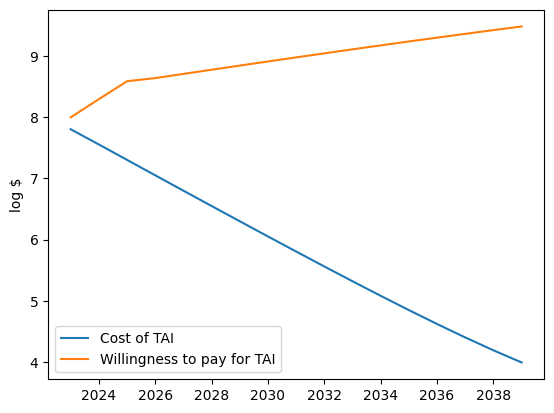

-
-
## SAMPLE RUN 2 ##
It takes 31.2 log FLOP (~16 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~97 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~501 million). This doubles every 1.0 years until 2025, and then doubles every 4.3 years to a max of 0.000262% of GDP. GDP grows at a rate of 1.012x per year.
---
Year: 2023 - 27.0 max log FLOP (923 septillion) available - TAI takes 31.2 log FLOP (16 nonillion) - log $ 12.9 to buy TAI (8 trillion) vs. willingness to pay log $ 8.7 (463 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.4 max log FLOP (2 octillion) available - TAI takes 31.1 log FLOP (12 nonillion) - log $ 12.6 to buy TAI (4 trillion) vs. willingness to pay log $ 8.9 (877 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 -

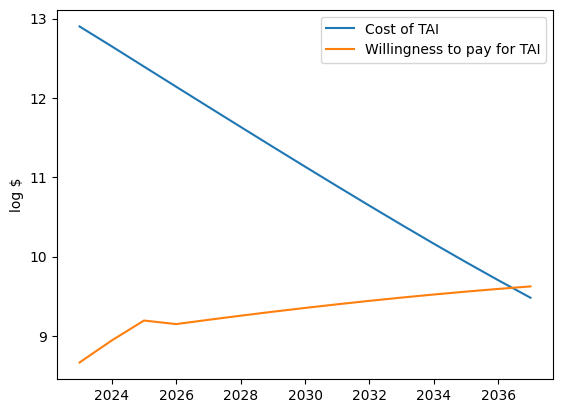

-
-
## SAMPLE RUN 3 ##
It takes 33.2 log FLOP (~2 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~9 sextillion) per 2022$USD.
We are initially willing to pay 7.9 log 2022$USD (~79 million). This doubles every 1.0 years until 2025, and then doubles every 2.9 years to a max of 1e-06% of GDP. GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 25.3 max log FLOP (21 septillion) available - TAI takes 33.2 log FLOP (2 decillion) - log $ 14.9 to buy TAI (795 trillion) vs. willingness to pay log $ 7.0 (11 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 25.5 max log FLOP (31 septillion) available - TAI takes 33.1 log FLOP (1 decillion) - log $ 14.6 to buy TAI (429 trillion) vs. willingness to pay log $ 7.1 (12 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 25.6

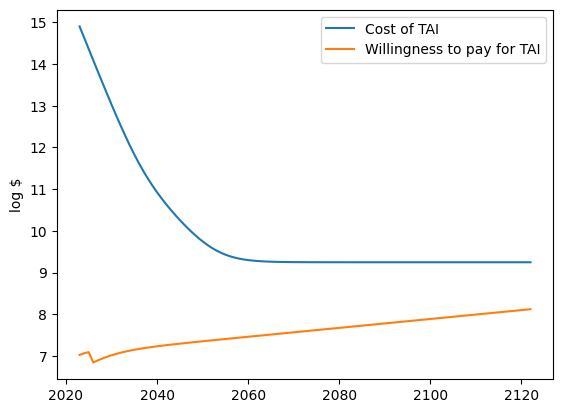

-
-
## RUN TIMELINES MODEL ##
Generating Bayes net...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:46<00:00, 44.16it/s]


Caching in-memory...
...Cached!
Writing cache to file `caches/tai_years.sqcache`...
...Cached!
...Reducing
...Reduced!
...All done!
-
## DISTRIBUTION OF TAI ARRIVAL DATE ##
['5%: 2032',
 '10%: 2034',
 '15%: 2036',
 '20%: 2038',
 '25%: 2039',
 '35%: 2042',
 '50%: 2049',
 '60%: 2055',
 '75%: >2123',
 '80%: >2123',
 '90%: >2123',
 '95%: >2123']
-
-
## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['5%: 9 years from now',
 '10%: 11 years from now',
 '15%: 13 years from now',
 '20%: 15 years from now',
 '25%: 16 years from now',
 '35%: 19 years from now',
 '50%: 26 years from now',
 '60%: 32 years from now',
 '75%: >100 years from now',
 '80%: >100 years from now',
 '90%: >100 years from now',
 '95%: >100 years from now']
-
-
## TAI ARRIVAL DATE BY BIN ##
This year: 0.0%
2024-2027: 0.2%
2028-2029: 1.3%
2030-2034: 9.8%
2035-2039: 14.8%
2040-2049: 25.3%
2050-2059: 12.4%
2060-2069: 5.1%
2070-2079: 2.2%
2080-2089: 1.1%
2090-2099: 0.8%
2100-2109: 0.5%
2110-2119: 0.5%
>2120: 26.1%
-
-
## TAI ARRIV

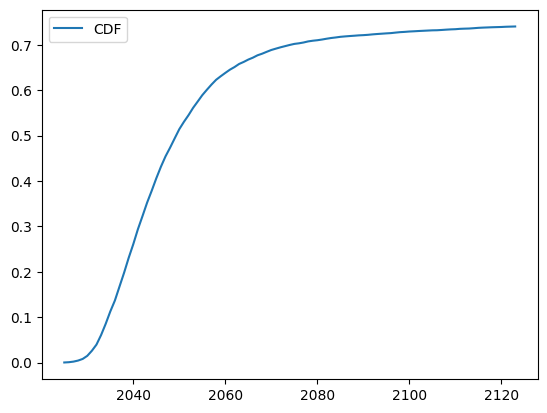

<string>:173: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<string>:174: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#d

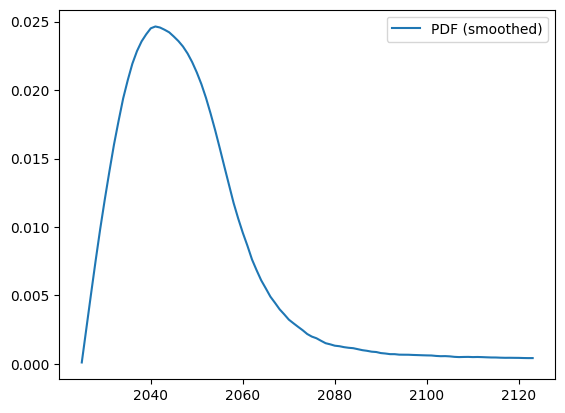

-
-
## TAI FLOP SIZE ##
{1: 25.0,
 5: 26.1,
 10: 27.0,
 20: 27.7,
 30: 28.7,
 40: 29.9,
 50: 31.4,
 60: 33.3,
 70: 35.1,
 80: 37.1,
 90: 41.1,
 95: 43.8,
 99: 49.4}


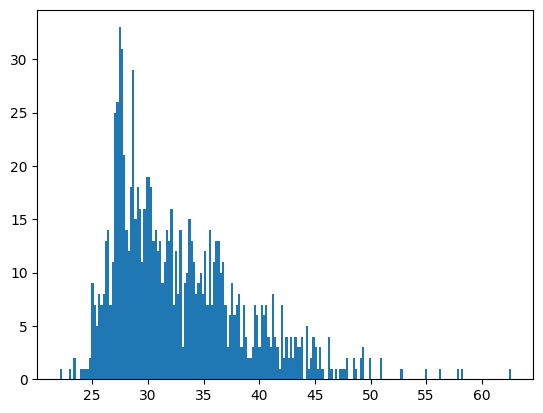

-
-
## MIN REDUCTION: 2 ##
-
## MAX REDUCTION: 5 ##
-
## MIN ALGO DOUBLING RATE: 1 ##
-
## MAX ALGO DOUBLING RATE: 3 ##
-
## INITIAL FLOP PER DOLLAR: 18.3 ##
-
## FLOP HALVING RATE ##
{1: 3.2,
 5: 3.0,
 10: 2.9,
 20: 2.8,
 30: 2.7,
 40: 2.6,
 50: 2.5,
 60: 2.4,
 70: 2.4,
 80: 2.3,
 90: 2.2,
 95: 2.0,
 99: 1.8}


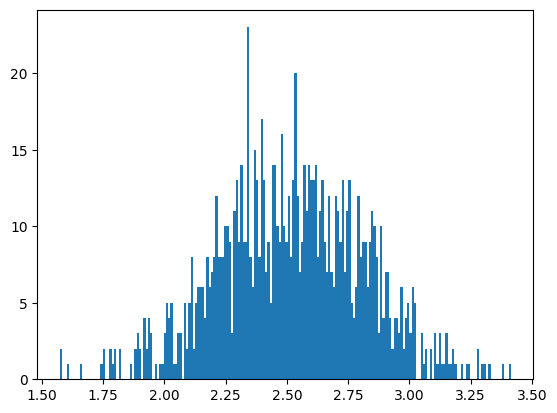

-
-
## MAX FLOP PER DOLLAR ##
{1: 20.4,
 5: 21.0,
 10: 21.3,
 20: 21.7,
 30: 22.0,
 40: 22.2,
 50: 22.4,
 60: 22.7,
 70: 22.9,
 80: 23.2,
 90: 23.7,
 95: 24.0,
 99: 24.6}


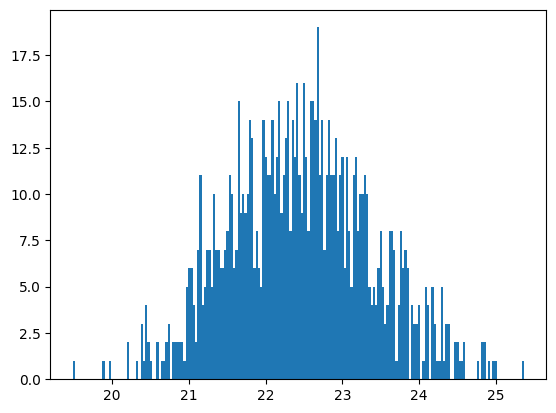

-
-
## INITIAL PAY ##
{1: 7.4,
 5: 7.6,
 10: 7.7,
 20: 7.9,
 30: 8.0,
 40: 8.1,
 50: 8.2,
 60: 8.3,
 70: 8.4,
 80: 8.6,
 90: 8.9,
 95: 9.3,
 99: 9.7}


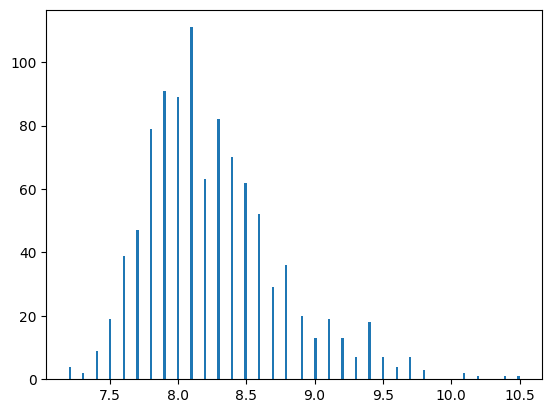

-
-
## GDP GROWTH ##
{1: 1.0,
 5: 1.01,
 10: 1.01,
 20: 1.02,
 30: 1.02,
 40: 1.02,
 50: 1.02,
 60: 1.02,
 70: 1.03,
 80: 1.03,
 90: 1.03,
 95: 1.03,
 99: 1.04}


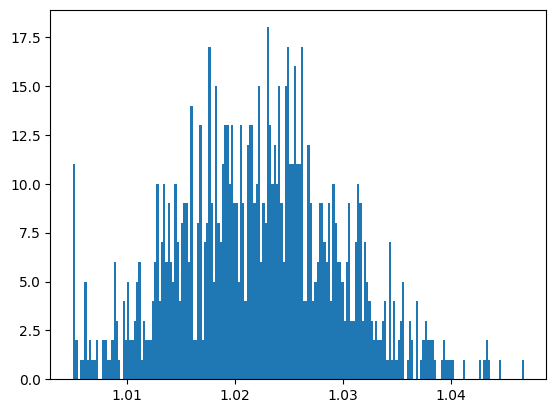

-
-
## MAX GDP FRAC ##
{1: 0.0,
 5: 1e-05,
 10: 7e-05,
 20: 0.00016,
 30: 0.00023,
 40: 0.00031,
 50: 0.00041,
 60: 0.00053,
 70: 0.00071,
 80: 0.00104,
 90: 0.00213,
 95: 0.00379,
 99: 0.01003}


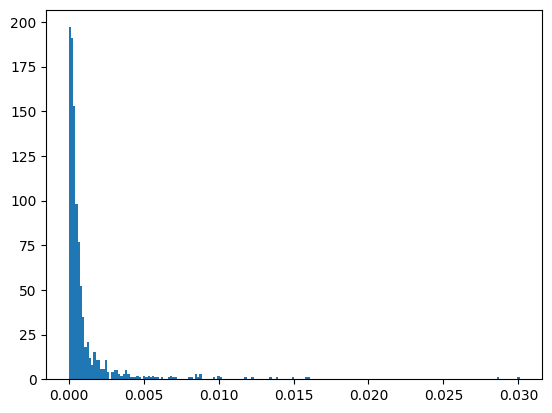

-
-
## SPEND DOUBLING TIME ##
{1: 5.0,
 5: 4.5,
 10: 4.2,
 20: 3.8,
 30: 3.5,
 40: 3.2,
 50: 3.0,
 60: 2.8,
 70: 2.5,
 80: 2.2,
 90: 1.8,
 95: 1.5,
 99: 1.0}


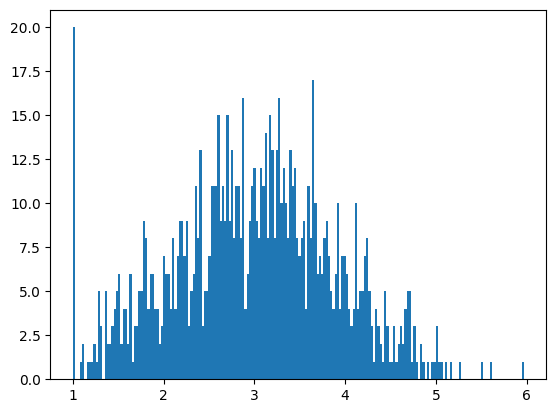

-
-
-
-
## GDP Over Time ##


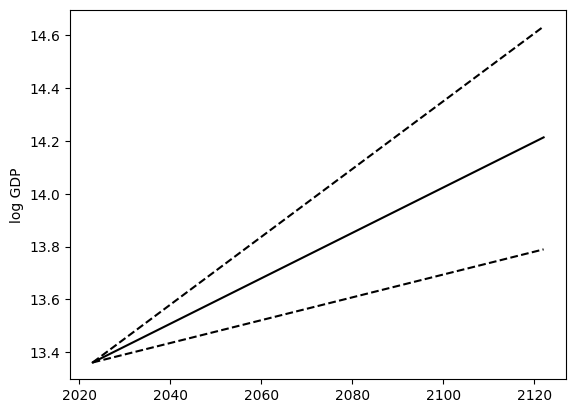

Year: 2023 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~23 trillion)
Year: 2024 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2025 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2026 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~25 trillion)
Year: 2027 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~26 trillion)
Year: 2028 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2029 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2030 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~28 trillion)
Year: 2031 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~29 trillion)
Year: 2032 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~30 trillion)
Year: 2033

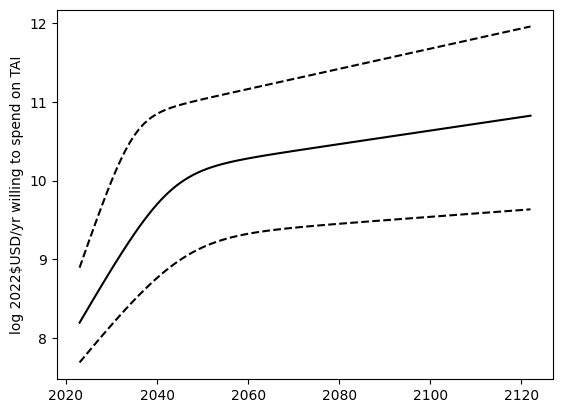

Year: 2023 - willingness log 2022$USD per year 8.2 (~156 million) 90% CI 7.7 (~49 million) - 8.9 (~782 million)
Year: 2024 - willingness log 2022$USD per year 8.3 (~196 million) 90% CI 7.8 (~57 million) - 9.1 (~1 billion)
Year: 2025 - willingness log 2022$USD per year 8.4 (~245 million) 90% CI 7.8 (~67 million) - 9.2 (~2 billion)
Year: 2026 - willingness log 2022$USD per year 8.5 (~307 million) 90% CI 7.9 (~78 million) - 9.4 (~2 billion)
Year: 2027 - willingness log 2022$USD per year 8.6 (~384 million) 90% CI 8.0 (~92 million) - 9.5 (~3 billion)
Year: 2028 - willingness log 2022$USD per year 8.7 (~480 million) 90% CI 8.0 (~107 million) - 9.7 (~5 billion)
Year: 2029 - willingness log 2022$USD per year 8.8 (~598 million) 90% CI 8.1 (~125 million) - 9.8 (~7 billion)
Year: 2030 - willingness log 2022$USD per year 8.9 (~744 million) 90% CI 8.2 (~146 million) - 10.0 (~10 billion)
Year: 2031 - willingness log 2022$USD per year 9.0 (~922 million) 90% CI 8.2 (~169 million) - 10.1 (~14 billion)


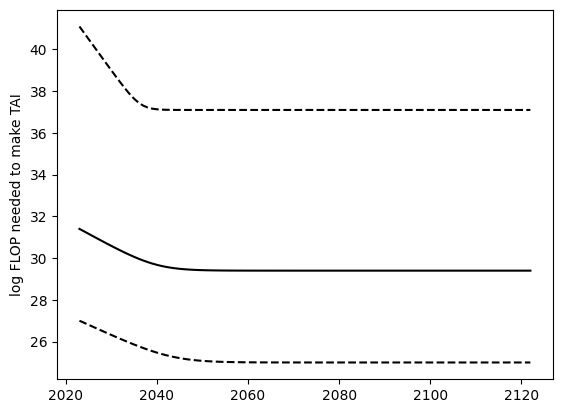

Year: 2023 - log FLOP needed for TAI 31.4 (~25 nonillion) 90% CI 27.0 (~1 octillion) - 41.1 (~126 million decillion)
Year: 2024 - log FLOP needed for TAI 31.3 (~19 nonillion) 90% CI 26.9 (~804 septillion) - 40.8 (~63 million decillion)
Year: 2025 - log FLOP needed for TAI 31.2 (~15 nonillion) 90% CI 26.8 (~640 septillion) - 40.5 (~31 million decillion)
Year: 2026 - log FLOP needed for TAI 31.0 (~11 nonillion) 90% CI 26.7 (~510 septillion) - 40.2 (~16 million decillion)
Year: 2027 - log FLOP needed for TAI 30.9 (~9 nonillion) 90% CI 26.6 (~407 septillion) - 39.9 (~8 million decillion)
Year: 2028 - log FLOP needed for TAI 30.8 (~7 nonillion) 90% CI 26.5 (~325 septillion) - 39.6 (~4 million decillion)
Year: 2029 - log FLOP needed for TAI 30.7 (~5 nonillion) 90% CI 26.4 (~260 septillion) - 39.3 (~2 million decillion)
Year: 2030 - log FLOP needed for TAI 30.6 (~4 nonillion) 90% CI 26.3 (~208 septillion) - 39.0 (~996 thousand decillion)
Year: 2031 - log FLOP needed for TAI 30.5 (~3 nonillion

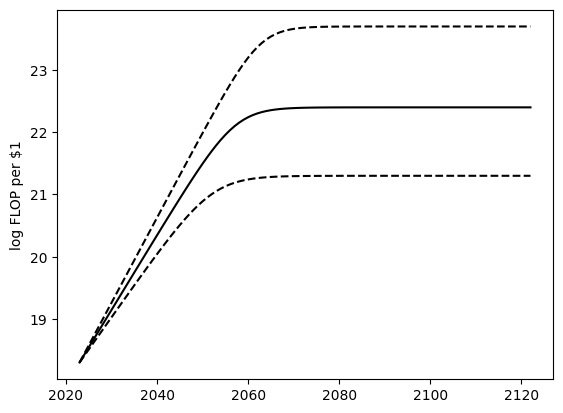

Year: 2023 - log FLOP per 2022$1USD 18.3 (~2 quintillion) 90% CI 18.3 (~2 quintillion) - 18.3 (~2 quintillion)
Year: 2024 - log FLOP per 2022$1USD 18.4 (~3 quintillion) 90% CI 18.4 (~3 quintillion) - 18.4 (~3 quintillion)
Year: 2025 - log FLOP per 2022$1USD 18.5 (~3 quintillion) 90% CI 18.5 (~3 quintillion) - 18.6 (~4 quintillion)
Year: 2026 - log FLOP per 2022$1USD 18.7 (~5 quintillion) 90% CI 18.6 (~4 quintillion) - 18.7 (~5 quintillion)
Year: 2027 - log FLOP per 2022$1USD 18.8 (~6 quintillion) 90% CI 18.7 (~5 quintillion) - 18.8 (~7 quintillion)
Year: 2028 - log FLOP per 2022$1USD 18.9 (~8 quintillion) 90% CI 18.8 (~7 quintillion) - 19.0 (~10 quintillion)
Year: 2029 - log FLOP per 2022$1USD 19.0 (~11 quintillion) 90% CI 18.9 (~8 quintillion) - 19.1 (~13 quintillion)
Year: 2030 - log FLOP per 2022$1USD 19.1 (~14 quintillion) 90% CI 19.0 (~11 quintillion) - 19.3 (~18 quintillion)
Year: 2031 - log FLOP per 2022$1USD 19.3 (~18 quintillion) 90% CI 19.1 (~13 quintillion) - 19.4 (~25 quint

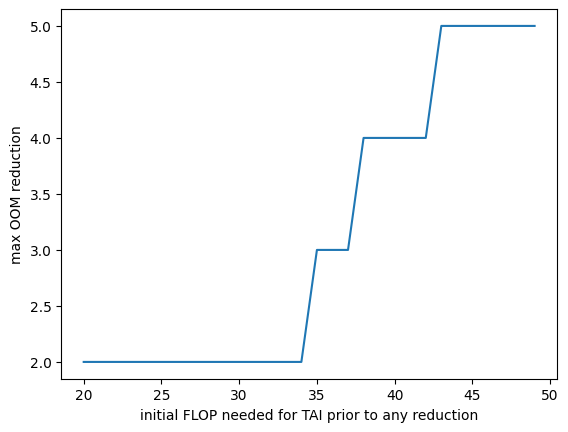

TAI log FLOP 20 -> 2.0 OOM reductions possible
TAI log FLOP 21 -> 2.0 OOM reductions possible
TAI log FLOP 22 -> 2.0 OOM reductions possible
TAI log FLOP 23 -> 2.0 OOM reductions possible
TAI log FLOP 24 -> 2.0 OOM reductions possible
TAI log FLOP 25 -> 2.0 OOM reductions possible
TAI log FLOP 26 -> 2.0 OOM reductions possible
TAI log FLOP 27 -> 2.0 OOM reductions possible
TAI log FLOP 28 -> 2.0 OOM reductions possible
TAI log FLOP 29 -> 2.0 OOM reductions possible
TAI log FLOP 30 -> 2.0 OOM reductions possible
TAI log FLOP 31 -> 2.0 OOM reductions possible
TAI log FLOP 32 -> 2.0 OOM reductions possible
TAI log FLOP 33 -> 2.0 OOM reductions possible
TAI log FLOP 34 -> 2.0 OOM reductions possible
TAI log FLOP 35 -> 3.0 OOM reductions possible
TAI log FLOP 36 -> 3.0 OOM reductions possible
TAI log FLOP 37 -> 3.0 OOM reductions possible
TAI log FLOP 38 -> 4.0 OOM reductions possible
TAI log FLOP 39 -> 4.0 OOM reductions possible
TAI log FLOP 40 -> 4.0 OOM reductions possible
TAI log FLOP 

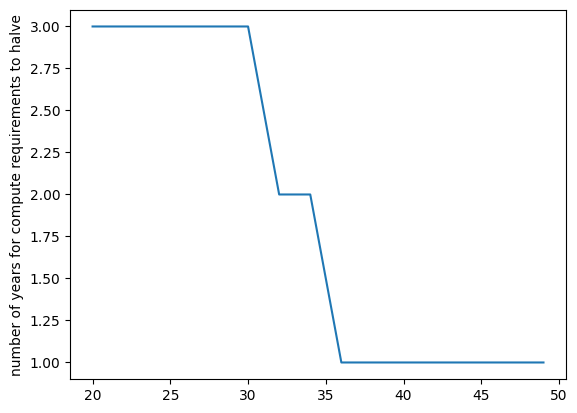

TAI log FLOP 20 -> algo doubling rate 3.0yrs
TAI log FLOP 21 -> algo doubling rate 3.0yrs
TAI log FLOP 22 -> algo doubling rate 3.0yrs
TAI log FLOP 23 -> algo doubling rate 3.0yrs
TAI log FLOP 24 -> algo doubling rate 3.0yrs
TAI log FLOP 25 -> algo doubling rate 3.0yrs
TAI log FLOP 26 -> algo doubling rate 3.0yrs
TAI log FLOP 27 -> algo doubling rate 3.0yrs
TAI log FLOP 28 -> algo doubling rate 3.0yrs
TAI log FLOP 29 -> algo doubling rate 3.0yrs
TAI log FLOP 30 -> algo doubling rate 3.0yrs
TAI log FLOP 31 -> algo doubling rate 2.5yrs
TAI log FLOP 32 -> algo doubling rate 2.0yrs
TAI log FLOP 33 -> algo doubling rate 2.0yrs
TAI log FLOP 34 -> algo doubling rate 2.0yrs
TAI log FLOP 35 -> algo doubling rate 1.5yrs
TAI log FLOP 36 -> algo doubling rate 1.0yrs
TAI log FLOP 37 -> algo doubling rate 1.0yrs
TAI log FLOP 38 -> algo doubling rate 1.0yrs
TAI log FLOP 39 -> algo doubling rate 1.0yrs
TAI log FLOP 40 -> algo doubling rate 1.0yrs
TAI log FLOP 41 -> algo doubling rate 1.0yrs
TAI log FL

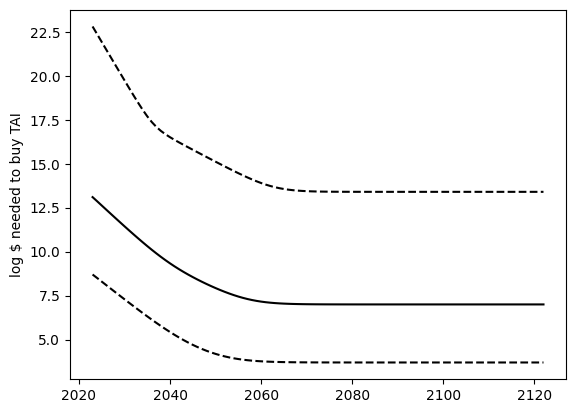

Year: 2023 - 13.1 log 2022$USD to buy TAI (~13 trillion) 90% CI 8.7 (~502 million) - 22.8 (~63 sextillion)
Year: 2024 - 12.9 log 2022$USD to buy TAI (~7 trillion) 90% CI 8.5 (~318 million) - 22.4 (~23 sextillion)
Year: 2025 - 12.6 log 2022$USD to buy TAI (~4 trillion) 90% CI 8.3 (~199 million) - 21.9 (~8 sextillion)
Year: 2026 - 12.4 log 2022$USD to buy TAI (~2 trillion) 90% CI 8.1 (~125 million) - 21.5 (~3 sextillion)
Year: 2027 - 12.1 log 2022$USD to buy TAI (~1 trillion) 90% CI 7.9 (~79 million) - 21.0 (~1 sextillion)
Year: 2028 - 11.9 log 2022$USD to buy TAI (~819 billion) 90% CI 7.7 (~49 million) - 20.6 (~409 quintillion)
Year: 2029 - 11.7 log 2022$USD to buy TAI (~476 billion) 90% CI 7.5 (~31 million) - 20.2 (~150 quintillion)
Year: 2030 - 11.4 log 2022$USD to buy TAI (~278 billion) 90% CI 7.3 (~20 million) - 19.7 (~55 quintillion)
Year: 2031 - 11.2 log 2022$USD to buy TAI (~163 billion) 90% CI 7.1 (~12 million) - 19.3 (~20 quintillion)
Year: 2032 - 11.0 log 2022$USD to buy TAI (

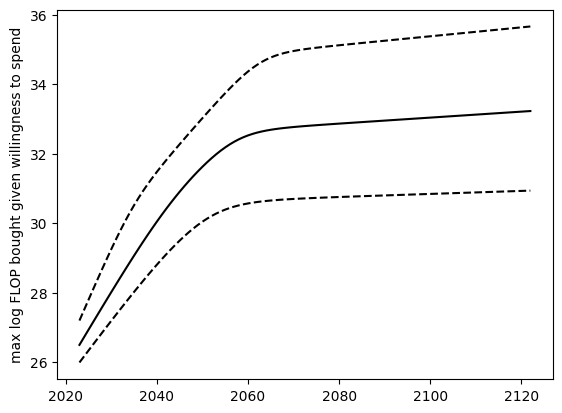

Year: 2023 - max log FLOP 26.5 (~311 septillion) 90% CI 26.0 (~97 septillion) - 27.2 (~2 octillion)
Year: 2024 - max log FLOP 26.7 (~515 septillion) 90% CI 26.2 (~144 septillion) - 27.5 (~3 octillion)
Year: 2025 - max log FLOP 26.9 (~852 septillion) 90% CI 26.3 (~215 septillion) - 27.8 (~6 octillion)
Year: 2026 - max log FLOP 27.1 (~1 octillion) 90% CI 26.5 (~320 septillion) - 28.1 (~12 octillion)
Year: 2027 - max log FLOP 27.4 (~2 octillion) 90% CI 26.7 (~475 septillion) - 28.4 (~24 octillion)
Year: 2028 - max log FLOP 27.6 (~4 octillion) 90% CI 26.8 (~704 septillion) - 28.7 (~48 octillion)
Year: 2029 - max log FLOP 27.8 (~6 octillion) 90% CI 27.0 (~1 octillion) - 29.0 (~93 octillion)
Year: 2030 - max log FLOP 28.0 (~10 octillion) 90% CI 27.2 (~2 octillion) - 29.3 (~178 octillion)
Year: 2031 - max log FLOP 28.2 (~17 octillion) 90% CI 27.4 (~2 octillion) - 29.5 (~336 octillion)
Year: 2032 - max log FLOP 28.4 (~28 octillion) 90% CI 27.5 (~3 octillion) - 29.8 (~618 octillion)
Year: 2033 

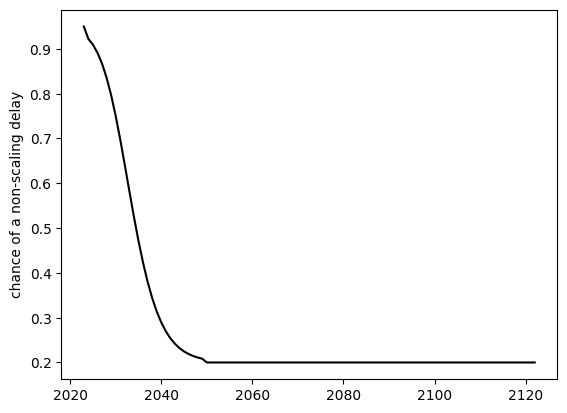

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 92%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 91%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 89%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 87%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 84%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 80%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 75%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 64%
Year: 2033

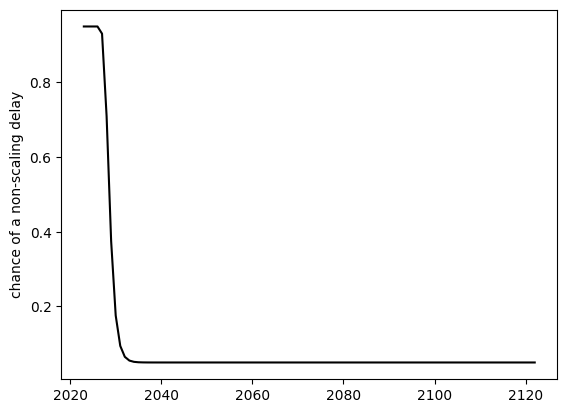

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 93%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 71%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 37%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 9%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 7%
Year: 2033 -

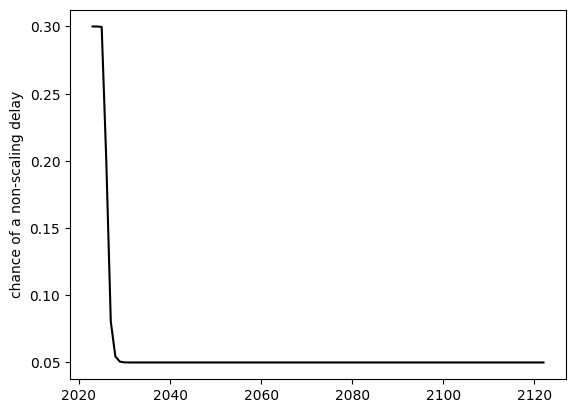

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 8%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2033 - cha

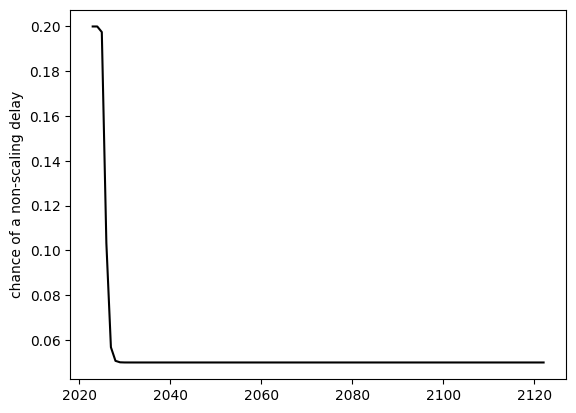

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2033 - cha

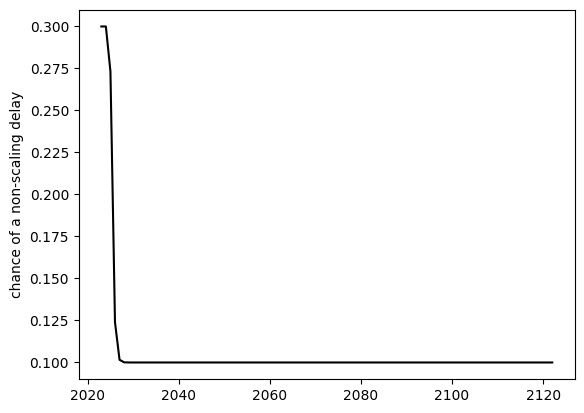

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 27%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 12%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2033

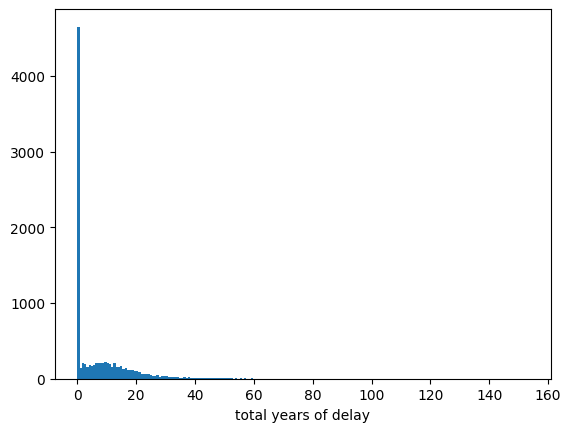

In [7]:
variables['RUNS'] = RUNS
variables['CURRENT_YEAR'] = CURRENT_YEAR
variables['MAX_YEAR'] = MAX_YEAR
run_timelines_model(variables,
                    cores=1,
                    runs=variables['RUNS'],
                    #dump_cache_file='caches/tai_years_metaculus_parity')
                    dump_cache_file='caches/tai_years')
